This notebook is an amalgam of the efficiency -> correction matrix parts of the other notebooks

In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import pandas as pd
import numpy as np
from scipy.signal import argrelmax
from scipy.optimize import curve_fit
from scipy.stats import linregress
import IPython.display
import os

import math
from itertools import takewhile

# Copy pasted helper functions

In [2]:
def is_between(data, lower, upper):
    return np.logical_and(data >= lower, data < upper)

def between(data, lower, upper):
    return data[is_between(data, lower, upper)]

#TODO axis, more dimensions
def is_around(data, point, range):
    return is_between(data, point - range, point+range)
    
def around(data, point, range):
    return data[is_around(data, point, range)]

np.is_between = is_between
np.between    = between
np.is_around  = is_around
np.around     = around

In [3]:
def read_file(folder_name = "./", file_name="B4_nt_B4_t%i.csv", num_threads=4, column_names = ["Energy", "Track_length"]):
    file_name = folder_name + file_name
    
    data = pd.read_csv (file_name % 0, comment="#", header=None, names=column_names)
    for i in range(1, num_threads):
        data = data.append(pd.read_csv (file_name % i, comment="#", header=None, names=column_names))
    
    return data

def read_with_angle (dir_name, num_threads=4):
    data_with_angle = read_file(dir_name, column_names=["Energy", "Track_length", "p_X", "p_Y", "p_Z"], num_threads=num_threads)
    data_with_angle["angle"] = np.arccos(np.dot(data_with_angle[["p_X", "p_Y", "p_Z"]], [0,0,1]))
    return data_with_angle

def read_distance_folders (base_folder_name, dists, num_threads=4):
    datas = []
    
    for dist in dists:
        datas.append(read_with_angle (base_folder_name + "/%i/" % dist, num_threads=num_threads))
    
    return datas

In [4]:
def count_hit_ratio_around_peaks (data, peaks, radius = 0.005):
    hits_around_peak = []
    
    for _, (isotope, E, p, p_norm) in peaks.iterrows():
        hits_around_peak.append([E, np.is_around(data, E, radius).sum() / len(data)])
    
    return np.array(hits_around_peak)

In [5]:
def calculate_full_efficiency (data, cutoff = 0):
    return (data > cutoff).sum() / len(data)

In [6]:
def get_efficiencies_of_mono_energies (mono_energies, mono_datas):
    photo_efficiencies = []
    full_efficiencies  = []
    
    for mono_run_set in mono_datas:
        photo = []
        full  = []
        for energy, data in zip(mono_energies, mono_run_set):
            mono_peak        = pd.DataFrame({"E_MeV" : [energy/1000]}, columns=["A", "E_MeV", "B", "C"])
            hits_on_peak     = count_hit_ratio_around_peaks(data["Energy"], peaks=mono_peak)[0][1]
            photo_efficiency = hits_on_peak / 2                       #Half sphere angular distr.
            full_efficiency  = calculate_full_efficiency(data)[0] / 2 #Half sphere angular distr.
            
            photo.append(photo_efficiency)
            full.append(full_efficiency)
        
        photo_efficiencies.append(photo)
        full_efficiencies.append(full)
    
    return np.array(photo_efficiencies), np.array(full_efficiencies)

In [1460]:
fig_dir = "figures/"
fig_ext = ".svg"

def fig_name (name):
    return fig_dir + name + fig_ext

# Evaluation

In [1461]:
run_sets = {}

In [1462]:
def load_runset (dir_name, mono_energies = np.array([25, 60, 100, 150, 250, 600, 1000, 1500, 2500, 6000, 10000, 15000]), force=False):
    if dir_name not in run_sets or force:
        distances    = np.array(sorted([float(x) for x in os.listdir(dir_name)]))
        photo, total = read_efficiencies(dir_name, distances, mono_energies)
        
        run_sets[dir_name] = [distances, mono_energies, photo, total]
    
    return run_sets[dir_name]

## Reading efficiencies

In [1463]:
distances, mono_energies, photo, total = load_runset ("runs/2021_05_28-04_46_34/mono_real_geom_distance_energy/")
fig_dir = "figures/long_distance_efficiencies/"

In [1464]:
def read_efficiencies (dir_name, distances, mono_energies):
    folder_reader = lambda distance: read_distance_folders(dir_name + "/%g" % distance, dists=mono_energies, num_threads=8)
    datasets = (folder_reader(distance) for distance in distances)
    return get_efficiencies_of_mono_energies(mono_energies, datasets)

In [1465]:
def fit_efficiencies (photo_efficiencies, full_efficiencies):
    coeffs_photo = np.polyfit(np.log10(mono_energies), np.log10(photo_efficiencies), 5)
    p_photo      = np.poly1d(coeffs_photo)

    coeffs_total = np.polyfit(np.log10(mono_energies), np.log10(full_efficiencies), 5)
    p_total      = np.poly1d(coeffs_total)

    print("Photopeak:", coeffs_photo)
    print("Total:    ", coeffs_total)
    
    x = np.linspace(1.2, 4.3, 100)
    plt.figure()
    plt.plot(x, p_photo(x), label="5th order photopeak fit", alpha=0.5)
    plt.plot(np.log10(mono_energies), np.log10(photo_efficiencies), "o", label="Simulated photopeak");

    plt.plot(x, p_total(x), label="5th order total fit", alpha=0.5)
    plt.plot(np.log10(mono_energies), np.log10(full_efficiencies) , "o", label="Simulated total");

    plt.xlabel("$\log_{10}$(Energy [keV])")
    plt.ylabel("$\log_{10}$(Efficiency)")

    plt.legend()
    plt.show()

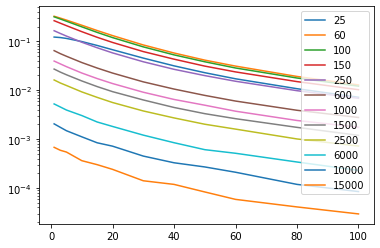

In [1466]:
for E_ind in range(len(mono_energies)):
    plt.plot(distances, photo[:, E_ind], label=mono_energies[E_ind])

plt.yscale("log")
plt.legend();

In [1467]:
def linear(x, x_0, m):
    return (x - x_0) * m

def get_r_0s(data, name):
    r_0s = []
    
    plt.figure()
    
    xx = np.linspace(-30, distances.max()+5, 1000)
    for E_ind in range(len(mono_energies)):
        plt.plot(distances, 1/np.sqrt(data[:, E_ind]), label=mono_energies[E_ind])
        
        p_opt, p_cov = curve_fit(linear, distances, 1/np.sqrt(data[:, E_ind]))
        
        plt.plot(xx, linear(xx, *p_opt), alpha=0.3)
        plt.xlabel("r [mm]")
        plt.ylabel(r"$\mu^{-\frac{1}{2}}$")
        
        r_0s.append([-p_opt[0], np.sqrt(p_cov[0, 0])])
        
        plt.savefig(fig_name("fit_r0s_%s" % name), bbox_inches="tight")
    
    return np.array(r_0s)

In [1468]:
def fit_r_0(r_0s, r0_shape, color=None, name=None):
    p0 = np.array([r_0s[-1, 0] - r_0s[1, 0], 0.01, r_0s[1, 0]])
    p_opt, p_cov = curve_fit(r0_shape, mono_energies[2:], r_0s[2:, 0], p0=p0)
    
    xx = np.linspace(mono_energies[0], mono_energies[-1], 1000)
    plt.plot(xx, r0_shape(xx, *p_opt), alpha=0.3, label=None if name is None else name + " fit")
    plt.errorbar(mono_energies, r_0s[:, 0], r_0s[:, 1], fmt="o", alpha=0.6, color=color, label=name)
    
    plt.xscale("log")
    
    #if the first point is too much of an outlier then don't zoom out that much, leave it be out of plot
    y0, y1 = plt.ylim()
    if r_0s[0, 0] > r_0s[-1, 0] * 2:
        plt.ylim(r_0s[1:, 0].min() - 2, r_0s[1:, 0].max() + 2)
    
    return lambda E: r0_shape(E, *p_opt)

In [1469]:
def r_0 (E, p1, p2, p3):
    return p1 * (1 - np.exp(-p2*E + p3))

In [1470]:
def get_r0_functions (photo, total, r0_shape):
    r_0_photo_data = get_r_0s(photo, name="photo")
    r_0_total_data = get_r_0s(total, name="total")
    
    plt.figure()
    
    photo_r0 = fit_r_0(r_0_photo_data, r0_shape=r0_shape, color="C0", name="Photo")
    total_r0 = fit_r_0(r_0_total_data, r0_shape=r0_shape, color="C1", name="Total")
    
    plt.xlabel("Energy [keV]")
    plt.ylabel("$r_0$ [mm]")
    
    plt.legend()
    plt.savefig(fig_name("r0_fit"), bbox_inches="tight")
    
    return r_0_photo_data, r_0_total_data, photo_r0, total_r0

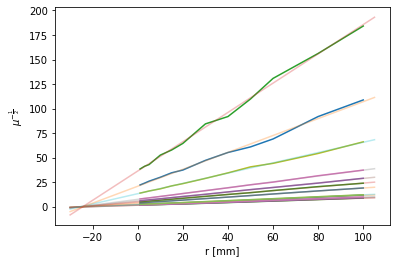

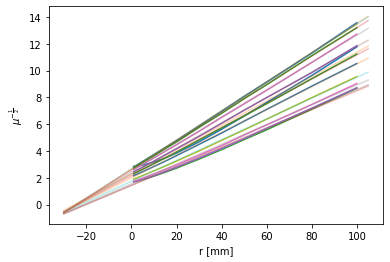

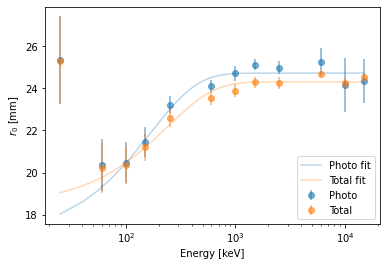

In [1471]:
r_0_photo_data, r_0_total_data, photo_r0, total_r0 = get_r0_functions(photo, total, r0_shape=r_0)

In [1472]:
def corr_ratio(r, E, f_r0):
    r0 = f_r0(E)
    return 1 / (4 * np.pi * ((r + r0)**2 / r0**2))

def eff_func(f_r0):
    def eff (X, p0, p1, p2, p3, p4, p5):
        d, E = X.T
        return 10**np.poly1d([p0, p1, p2, p3, p4, p5])(np.log10(E)) * corr_ratio(d, E, f_r0)
    
    return eff

In [1473]:
def fit_at_distance(data, dist_ind, f_r0):
    corr_ratios = corr_ratio(distances[dist_ind], mono_energies, f_r0)
    
    poly_0 = np.polyfit(np.log10(mono_energies),
                        np.log10(data[dist_ind] / corr_ratios), 5)
    
    plt.plot(mono_energies, data[dist_ind], "o")
    
    X = np.vstack(([distances[4]]*len(mono_energies), mono_energies)).T
    plt.plot(mono_energies, eff_func (f_r0)(X, *poly_0))
    
    plt.xscale("log")
    plt.yscale("log")
    
    return poly_0

In [1474]:
def plot_2d_fit_ratio(data, fitted, name):
    plt.figure()
    plt.imshow(data / fitted, cmap="bwr", origin="lower")
    plt.clim(0.5, 1.5)
    
    plt.xticks(range(len(mono_energies)), rotation=-90)
    plt.yticks(range(len(distances)))
    plt.gca().set_xticklabels(["%g" % E for E in mono_energies])
    plt.gca().set_yticklabels(["%g" % d for d in distances])
    
    plt.xlabel("Energy [keV]")
    plt.ylabel("Distance [mm]")
    
    plt.colorbar(label="Data / fit eff. ratio")
    plt.savefig(fig_name("efficiency_2d_%s" % name), bbox_inches="tight")

In [1475]:
def fit_efficiencies (data, f_r0, name, d_slice=slice(None), E_slice=slice(1, -1)):
    d_, E_ = np.meshgrid(distances[d_slice], mono_energies[E_slice])
    d__ = d_.ravel()
    E__ = E_.ravel()
    X = np.vstack((d__, E__))
    
    Y = data[d_slice, E_slice]
    
    eff = eff_func(f_r0)
    
    p_opts, p_cov = curve_fit(eff, X.T, Y.T.ravel(), p0=fit_at_distance(data, 4, f_r0))
    
    f_eff = lambda d, E: eff(np.vstack((d, E)).T, *p_opts)
    
    fitted = np.zeros (data.shape)
    
    for d in range(fitted.shape[0]):
        for E in range(fitted.shape[1]):
            fitted[d, E] = f_eff(distances[d], mono_energies[E])
    
    plt.figure()
    plt.imshow(fitted)
    plt.colorbar()
    plt.show()
    
    plot_2d_fit_ratio (data, fitted, name)
    
    return p_opts, f_eff, fitted

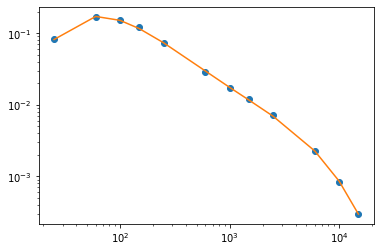

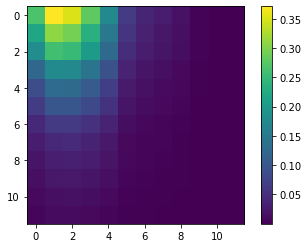

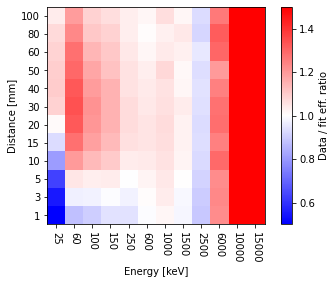

In [1476]:
p_opts, f_eff, fitted = fit_efficiencies(photo, photo_r0, "photo")

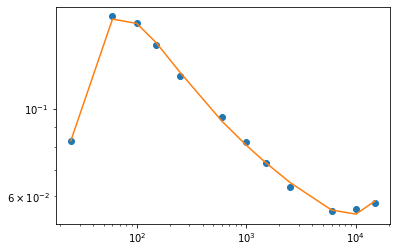

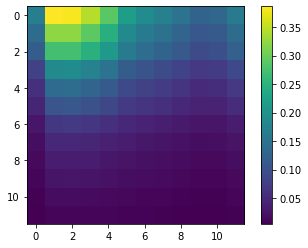

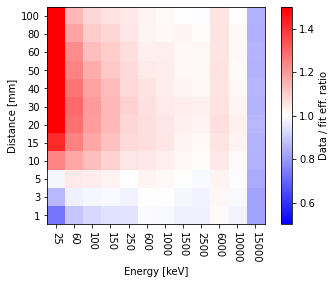

In [1477]:
fit_efficiencies(full, total_r0, "total");

## Short distances

In [1478]:
distances, mono_energies, photo, total = load_runset ("data/2021_05_27-05_46_45/mono_real_geom_distance_energy")
fig_dir = "figures/short_distance_efficiencies/"

In [1479]:
def r_0_down(E, p1, p2, p3):
    return  p1 + np.exp(-p2 * E + p3)

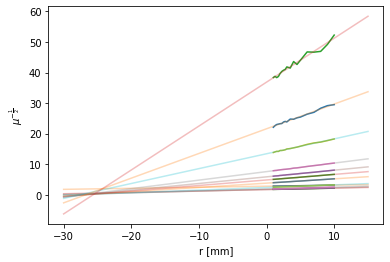

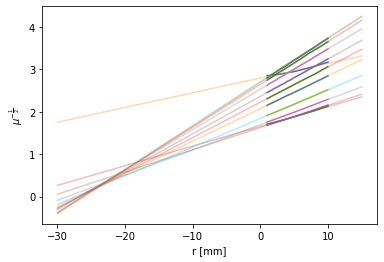

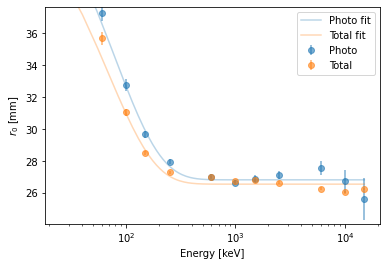

In [1481]:
r_0_photo_data, r_0_total_data, photo_r0, total_r0 = get_r0_functions(photo, total, r_0_down)

In [1482]:
photo.shape

(18, 12)

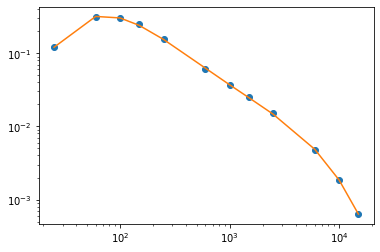

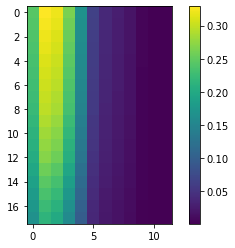

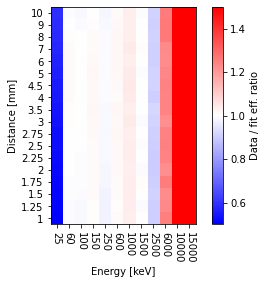

In [1483]:
fit_efficiencies(photo, photo_r0, "photo");

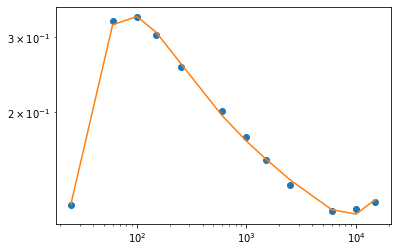

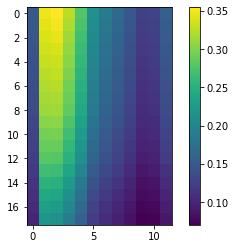

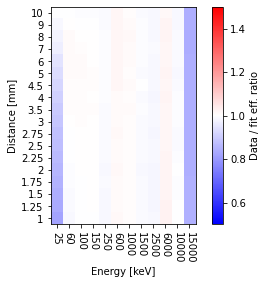

In [1484]:
fit_efficiencies(total, total_r0, "total");

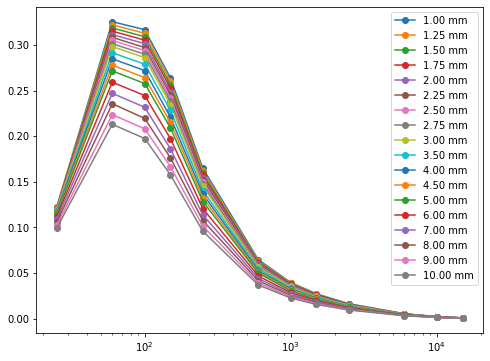

In [1485]:
plt.figure(figsize=(8,6))
for d_ind in range(len(distances)):
    plt.plot(mono_energies, photo[d_ind, :], "-o", label="%0.2f mm" % distances[d_ind])

plt.xscale("log")
plt.legend();
plt.savefig(fig_name("all_dist_Ecurves"), bbox_inches="tight")